In [1]:
is_Ubuntu = True

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
if is_Ubuntu:
    H_Wildfires = pd.read_csv(r'../data/Nov_10/Historical_Wildfires.csv')
    H_Weather = pd.read_csv(r'../data/Nov_10/HistoricalWeather.csv')
    H_Weather_Fc = pd.read_csv(r'../data/Nov_10/HistoricalWeatherForecasts.csv')
    LandClass = pd.read_csv(r'../data/Nov_10/LandClass.csv')
    Vege = pd.read_csv(r'../data/Nov_10/VegetationIndex.csv')
else:
    H_Wildfires = pd.read_csv(r'..\data\Nov_10\Historical_Wildfires.csv')
    H_Weather = pd.read_csv(r'..\data\Nov_10\HistoricalWeather.csv')
    H_Weather_Fc = pd.read_csv(r'..\data\Nov_10\HistoricalWeatherForecasts.csv')
    LandClass = pd.read_csv(r'..\data\Nov_10\LandClass.csv')
    Vege = pd.read_csv(r'..\data\Nov_10\VegetationIndex.csv')

Delete rows with zero confidence

In [4]:
H_Wildfires = H_Wildfires.dropna() 

one of two input will be necessary in Std&Var to improve computation
I will keep Var and discard Std

In [5]:
H_Wildfires=H_Wildfires.drop(columns='Std_confidence')

In [6]:
if is_Ubuntu:
    Sample = pd.read_csv(r'../data/submission-example.csv')
else:
    Sample = pd.read_csv(r'..\data\submission-example.csv')

In [7]:
def reform(df, target_column, common_cols, key_cols, param_cols):
    elements = df[target_column].unique()
    basis = df[common_cols].drop_duplicates()
    for elm in elements:
        new = df[df[target_column] == elm][key_cols + param_cols]
        rename = {}
        for col in param_cols:
            rename[col] = str(elm) + '_' + col
        new = new.rename(columns=rename)
        basis = basis.merge(new, on=key_cols)
    return basis

In [8]:
target_column = 'Parameter'
common_cols = ['Date', 'Region', 'count()[unit: km^2]']
common_cols_fc = ['Date', 'Region', 'Lead time', 'count()[unit: km^2]']
key_cols = ['Date', 'Region']
key_cols_fc = ['Date', 'Region', 'Lead time']
param_cols = ['min()', 'max()', 'mean()', 'variance()']

H_Weather_reform = reform(H_Weather.copy(), target_column, common_cols, key_cols, param_cols)
H_Weather_Fc_reform = reform(H_Weather_Fc.copy(), target_column, common_cols_fc, key_cols_fc, param_cols)

In [9]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
# it is used to change only subset of column

In [10]:
ohe = OneHotEncoder(sparse=False)
ohe.fit_transform(H_Weather_reform[['Region']])

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [11]:
column_trans = make_column_transformer(
(OneHotEncoder(),['Region']), remainder='passthrough')
Weather_ohe1=column_trans.fit_transform(H_Weather_reform)
# now Region is transformed into one-hot encoder.

In [12]:
column_wo_Region=np.delete(H_Weather_reform.columns.values,1)

In [13]:
Weather_ohe=pd.DataFrame(Weather_ohe1,columns=np.concatenate((np.squeeze(np.array(ohe.categories_)),column_wo_Region)))
Weather_ohe=Weather_ohe.reindex(columns=['Date','NSW', 'NT', 'QL', 'SA', 'TA', 'VI', 'WA','count()[unit: km^2]', 'Precipitation_min()',
       'Precipitation_max()', 'Precipitation_mean()',
       'Precipitation_variance()', 'RelativeHumidity_min()',
       'RelativeHumidity_max()', 'RelativeHumidity_mean()',
       'RelativeHumidity_variance()', 'SoilWaterContent_min()',
       'SoilWaterContent_max()', 'SoilWaterContent_mean()',
       'SoilWaterContent_variance()', 'SolarRadiation_min()',
       'SolarRadiation_max()', 'SolarRadiation_mean()',
       'SolarRadiation_variance()', 'Temperature_min()', 'Temperature_max()',
       'Temperature_mean()', 'Temperature_variance()', 'WindSpeed_min()',
       'WindSpeed_max()', 'WindSpeed_mean()', 'WindSpeed_variance()'])

In [14]:
ohe2 = OneHotEncoder(sparse=False)
ohe2.fit_transform(H_Wildfires[['Region']])
column_trans = make_column_transformer(
(OneHotEncoder(),['Region']), remainder='passthrough')
H_Wildfires_ohe2=column_trans.fit_transform(H_Wildfires.copy())
# now Region is transformed into one-hot encoder.
H_Wildfires_ohe2
column_wo_Region2=np.delete(H_Wildfires.columns.values,0) # if the wrong column is deleted, change 0 to proper column.
H_Wildfires_ohe=pd.DataFrame(H_Wildfires_ohe2,columns=np.concatenate((np.squeeze(np.array(ohe2.categories_)),column_wo_Region2)))

In [15]:
H_Wildfires_ohe=H_Wildfires_ohe.drop(columns=['Replaced'])
# Delete Replaced. I believe it has no impact for the result.

In [16]:
H_Wildfires_ohe.Date=pd.to_datetime(H_Wildfires_ohe.Date)
Weather_ohe.Date=pd.to_datetime(Weather_ohe.Date)

In [17]:
Weather_ohe.iloc[24,0]==H_Wildfires_ohe.iloc[0,7] # It's same now.

True

In [18]:
Input = pd.merge(H_Wildfires_ohe, Weather_ohe, how='inner', on=['Date','NSW', 'NT', 'QL', 'SA', 'TA', 'VI', 'WA'])
Input = Input.sort_values(['Date'])

12 Dec. Use only one region's data, to see the performance of different models. Choose region WA because it has the most data.

In [19]:
df = Input[Input.WA == 1]
df = df.drop(columns = ['NSW', 'NT', 'QL', 'SA', 'TA', 'VI', 'WA', 'Date'])
num_features = df.shape[1]

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

In [18]:
df = Input.drop(columns = ['Date'])
num_features = df.shape[1]

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

df.astype(float)

# train_mean = train_df.mean()
# train_std = train_df.std()

# train_df = (train_df - train_mean) / train_std
# val_df = (val_df - train_mean) / train_std
# test_df = (test_df - train_mean) / train_std

,NSW,NT,QL,SA,TA,VI,WA,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,...,SolarRadiation_mean(),SolarRadiation_variance(),Temperature_min(),Temperature_max(),Temperature_mean(),Temperature_variance(),WindSpeed_min(),WindSpeed_max(),WindSpeed_mean(),WindSpeed_variance()
18623,0.0,0.0,0.0,0.0,0.0,0.0,1.0,36.382500,320.146875,100.750000,...,26.967495,19.931596,18.385500,36.411083,28.524055,17.695984,0.931396,10.650237,4.201039,1.409677
8941,0.0,0.0,1.0,0.0,0.0,0.0,0.0,38.831579,322.197368,45.757895,...,27.056979,29.500832,20.951620,37.047943,28.842866,13.792599,1.106028,7.675632,3.483753,0.883048
4051,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.945000,314.425000,47.500000,...,19.781791,58.942658,24.179960,38.136787,29.881492,12.920252,1.840394,9.704402,5.296892,1.930014
8942,0.0,0.0,1.0,0.0,0.0,0.0,0.0,64.464286,315.991071,58.492857,...,26.276294,27.100196,21.426340,35.675449,29.416449,10.519515,0.900613,7.094274,3.145954,0.951232
18624,0.0,0.0,0.0,0.0,0.0,0.0,1.0,148.106471,328.423529,578.464706,...,26.776612,29.720987,14.699057,37.955944,28.695349,28.801638,1.491437,12.510818,4.650767,2.707924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18622,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.000000,317.600000,46.700000,...,18.705855,6.353448,10.393755,17.675922,14.722631,2.395385,1.349514,7.834442,4.424107,2.182164
8940,0.0,1.0,0.0,0.0,0.0,0.0,0.0,115.588461,327.117308,218.473077,...,28.753237,2.531528,20.816809,34.729530,28.483307,11.273161,1.305594,5.900846,3.605941,0.644622
4050,1.0,0.0,0.0,0.0,0.0,0.0,0.0,20.276000,315.040000,88.460000,...,21.262570,16.523703,8.298871,22.036409,16.746594,7.320792,1.327121,7.461010,3.527583,0.745520
14295,0.0,0.0,1.0,0.0,0.0,0.0,0.0,297.627826,321.767150,61.613043,...,28.745128,4.796284,17.249844,32.112972,24.777835,8.811943,1.180556,7.643718,3.137745,0.549077


simple model (test)

In [19]:
df = pd.DataFrame({'A': np.linspace(0.0, 100.0, num=301), 'B': np.linspace(0.0, 100, num=301), 'Estimated_fire_area': np.linspace(0, 200, num=301)})
num_features = df.shape[1]

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

test_df.head()

,A,B,Estimated_fire_area
270,90.000000,90.000000,180.000000
271,90.333333,90.333333,180.666667
272,90.666667,90.666667,181.333333
273,91.000000,91.000000,182.000000
274,91.333333,91.333333,182.666667


In [20]:
import tensorflow as tf
import tensorflow
from tensorflow import keras
# from tensorflow.keras import layers
# from keras.layers import TimeDistributed
# from keras.layers.convolutional import Conv1D

## 1. Indexex and offsets

In [22]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=['Estimated_fire_area']):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

## 2. Split

In [23]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

## 3. Plot

In [24]:
def plot(self, model=None, plot_col='Estimated_fire_area', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Day')

WindowGenerator.plot = plot

## 4. Create tf.data.Datasets

In [25]:
def make_dataset(self, data):
    
  data = np.array(data, dtype=np.float32)    
#   data1 = np.array(data.drop(columns='Estimated_fire_area'), dtype=np.float32)
#   targets = np.array(data['Estimated_fire_area'], dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,  # If this is 7, Could it work as daily moving???
      shuffle=False,
      batch_size=16,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [26]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    print('No example batch was found, so get one from the `.train` dataset')
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [27]:
# MAX_EPOCHS = 200

def compile_and_fit(model, window, patience=30, epochs=100):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])
    
    history = model.fit(window.train, epochs=epochs,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

val_performance = {}
performance = {}

No example batch was found, so get one from the `.train` dataset


Total window size: 59
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]
Label indices: [31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54
 55 56 57 58]
Label column name(s): ['Estimated_fire_area']

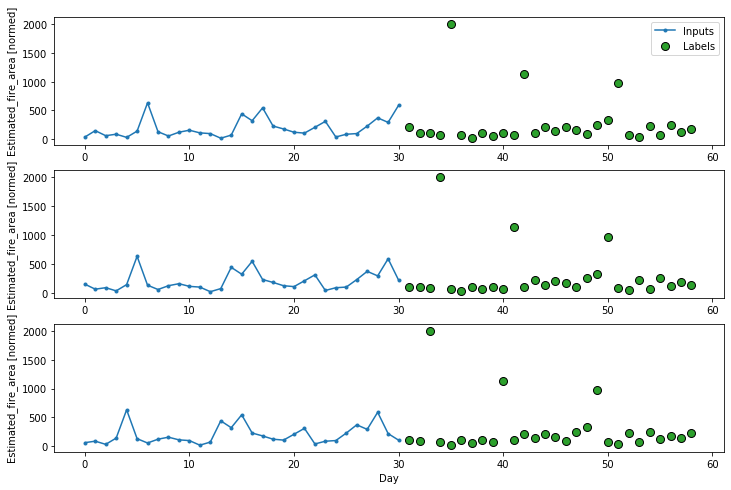

In [28]:
# WA region data
OUT_STEPS = 28
multi_window = WindowGenerator(input_width=31,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,label_columns=['Estimated_fire_area'],
                              train_df=train_df, val_df=val_df, test_df=test_df,)

multi_window.plot()
multi_window

In [28]:
# Each element is an (inputs, label) pair
multi_window.train.element_spec

(TensorSpec(shape=(None, 5, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None))

In [29]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.Dense(20),
    tf.keras.layers.GRU(50, return_sequences=True, return_state=False),
    tf.keras.layers.GRU(50), 
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS,
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS,1])
                          )])

In [30]:
def plot_history(history_object, plot_columns = ['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error']):
    fig_num = len(plot_columns)
    plt.figure(figsize=(12, 8))
    for n in range(fig_num):
        plt.subplot(fig_num, 1, n+1)
        plt.ylabel(plot_columns[n])
        plt.plot(history_object.history[plot_columns[n]])

Epoch 1/100
239/239 [==============================] - 7s 30ms/step - loss: 210300.8906 - mean_absolute_error: 226.2715 - val_loss: 331473.0938 - val_mean_absolute_error: 305.6522
Epoch 2/100
239/239 [==============================] - 7s 29ms/step - loss: 206968.5156 - mean_absolute_error: 219.4439 - val_loss: 327247.7500 - val_mean_absolute_error: 299.4104
Epoch 3/100
239/239 [==============================] - 8s 32ms/step - loss: 204034.8594 - mean_absolute_error: 214.0140 - val_loss: 323297.3750 - val_mean_absolute_error: 294.1021
Epoch 4/100
239/239 [==============================] - 9s 37ms/step - loss: 201294.6094 - mean_absolute_error: 209.3227 - val_loss: 319558.9062 - val_mean_absolute_error: 289.4769
Epoch 5/100
239/239 [==============================] - 6s 25ms/step - loss: 198719.0000 - mean_absolute_error: 205.2858 - val_loss: 316008.1562 - val_mean_absolute_error: 285.4486
Epoch 6/100
239/239 [==============================] - 5s 20ms/step - loss: 196293.3125 - mean_absol

239/239 [==============================] - 6s 25ms/step - loss: 161889.0469 - mean_absolute_error: 197.3189 - val_loss: 255894.1250 - val_mean_absolute_error: 261.9456
Epoch 47/100
239/239 [==============================] - 5s 21ms/step - loss: 161702.4219 - mean_absolute_error: 197.9637 - val_loss: 255238.0625 - val_mean_absolute_error: 262.3398
Epoch 48/100
239/239 [==============================] - 7s 31ms/step - loss: 161490.4219 - mean_absolute_error: 198.8115 - val_loss: 254328.6719 - val_mean_absolute_error: 262.9384
Epoch 49/100
239/239 [==============================] - 5s 23ms/step - loss: 161120.2812 - mean_absolute_error: 199.8972 - val_loss: 253860.9219 - val_mean_absolute_error: 263.2766
Epoch 50/100
239/239 [==============================] - 4s 19ms/step - loss: 160980.4531 - mean_absolute_error: 200.4171 - val_loss: 253488.3281 - val_mean_absolute_error: 263.5584
Epoch 51/100
239/239 [==============================] - 5s 20ms/step - loss: 160862.9062 - mean_absolute_err

239/239 [==============================] - 5s 21ms/step - loss: 159412.2188 - mean_absolute_error: 212.2791 - val_loss: 246841.7812 - val_mean_absolute_error: 270.1774
Epoch 92/100
239/239 [==============================] - 5s 21ms/step - loss: 159406.3281 - mean_absolute_error: 212.4137 - val_loss: 246784.4219 - val_mean_absolute_error: 270.2542
Epoch 93/100
239/239 [==============================] - 5s 21ms/step - loss: 159400.9219 - mean_absolute_error: 212.5437 - val_loss: 246729.4375 - val_mean_absolute_error: 270.3282
Epoch 94/100
239/239 [==============================] - 5s 21ms/step - loss: 159818.3125 - mean_absolute_error: 212.2935 - val_loss: 247472.0000 - val_mean_absolute_error: 269.3636
Epoch 95/100
239/239 [==============================] - 5s 22ms/step - loss: 159478.2656 - mean_absolute_error: 211.0182 - val_loss: 247396.8906 - val_mean_absolute_error: 269.4584
Epoch 96/100
239/239 [==============================] - 6s 24ms/step - loss: 159467.4219 - mean_absolute_err

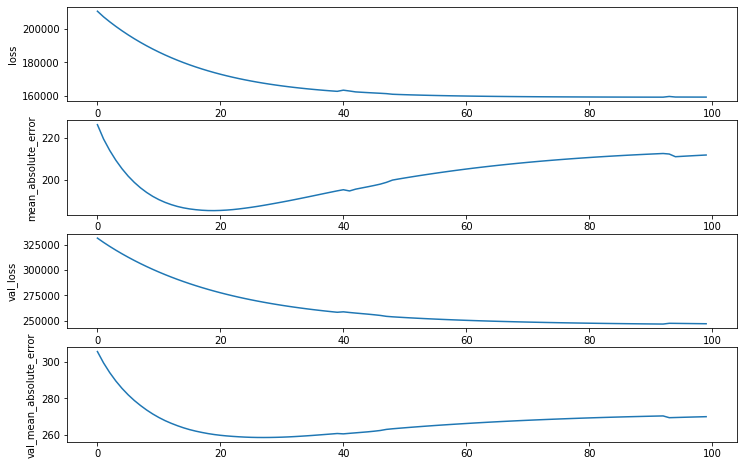

In [31]:
history2 = compile_and_fit(multi_lstm_model, multi_window, epochs=100)
plot_history(history2)

In [32]:
multi_lstm_model.predict(multi_window.val)

When I change to GRU instead of LSTM, it works better.

66/66 [==============================] - 1s 8ms/step - loss: 247038.7344 - mean_absolute_error: 269.9175


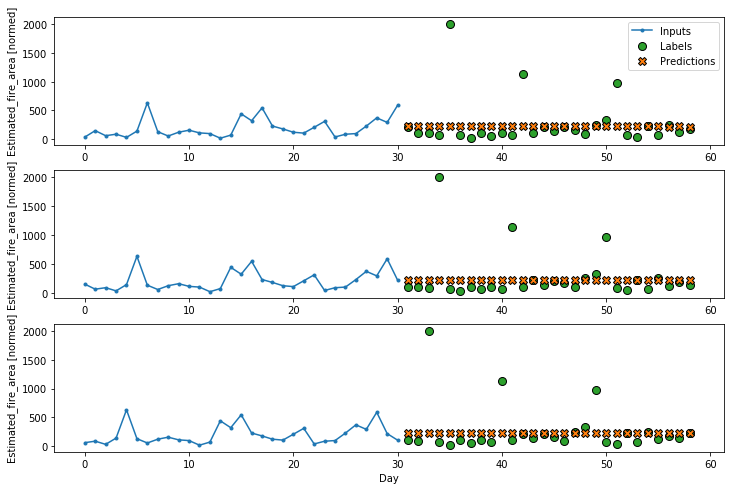

In [33]:
val_performance['M_LSTM'] = multi_lstm_model.evaluate(multi_window.val)
performance['M_LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

Epoch 1/500
239/239 [==============================] - 1s 5ms/step - loss: 3245518.7500 - mean_absolute_error: 490.8479 - val_loss: 337265.8438 - val_mean_absolute_error: 314.6752
Epoch 2/500
239/239 [==============================] - 1s 6ms/step - loss: 212722.3906 - mean_absolute_error: 231.1843 - val_loss: 337240.0000 - val_mean_absolute_error: 314.6341
Epoch 3/500
239/239 [==============================] - 1s 6ms/step - loss: 212700.3750 - mean_absolute_error: 231.1369 - val_loss: 337205.7812 - val_mean_absolute_error: 314.5798
Epoch 4/500
239/239 [==============================] - 1s 6ms/step - loss: 212672.6719 - mean_absolute_error: 231.0772 - val_loss: 337164.4375 - val_mean_absolute_error: 314.5141
Epoch 5/500
239/239 [==============================] - 1s 4ms/step - loss: 212639.9688 - mean_absolute_error: 231.0066 - val_loss: 337116.8125 - val_mean_absolute_error: 314.4384
Epoch 6/500
239/239 [==============================] - 1s 5ms/step - loss: 212602.8125 - mean_absolute_e

239/239 [==============================] - 1s 4ms/step - loss: 210222.0625 - mean_absolute_error: 225.8179 - val_loss: 333797.1562 - val_mean_absolute_error: 309.1995
Epoch 47/500
239/239 [==============================] - 1s 4ms/step - loss: 210160.6719 - mean_absolute_error: 225.6896 - val_loss: 333713.0000 - val_mean_absolute_error: 309.0687
Epoch 48/500
239/239 [==============================] - 1s 4ms/step - loss: 210099.3750 - mean_absolute_error: 225.5620 - val_loss: 333629.0000 - val_mean_absolute_error: 308.9384
Epoch 49/500
239/239 [==============================] - 1s 3ms/step - loss: 210038.1562 - mean_absolute_error: 225.4341 - val_loss: 333545.0312 - val_mean_absolute_error: 308.8083
Epoch 50/500
239/239 [==============================] - 1s 3ms/step - loss: 209976.8594 - mean_absolute_error: 225.3069 - val_loss: 333461.2188 - val_mean_absolute_error: 308.6783
Epoch 51/500
239/239 [==============================] - 1s 3ms/step - loss: 209915.7031 - mean_absolute_error: 22

239/239 [==============================] - 1s 5ms/step - loss: 207519.1719 - mean_absolute_error: 220.3793 - val_loss: 330082.5938 - val_mean_absolute_error: 303.5625
Epoch 92/500
239/239 [==============================] - 1s 6ms/step - loss: 207460.5312 - mean_absolute_error: 220.2664 - val_loss: 330001.7500 - val_mean_absolute_error: 303.4412
Epoch 93/500
239/239 [==============================] - 1s 6ms/step - loss: 207402.0000 - mean_absolute_error: 220.1539 - val_loss: 329920.8125 - val_mean_absolute_error: 303.3204
Epoch 94/500
239/239 [==============================] - 1s 5ms/step - loss: 207343.3906 - mean_absolute_error: 220.0418 - val_loss: 329840.0625 - val_mean_absolute_error: 303.1999
Epoch 95/500
239/239 [==============================] - 1s 5ms/step - loss: 207284.9844 - mean_absolute_error: 219.9300 - val_loss: 329759.3750 - val_mean_absolute_error: 303.0795
Epoch 96/500
239/239 [==============================] - 1s 5ms/step - loss: 207226.6094 - mean_absolute_error: 21

239/239 [==============================] - 1s 5ms/step - loss: 204938.4531 - mean_absolute_error: 215.5621 - val_loss: 326509.1562 - val_mean_absolute_error: 298.3664
Epoch 137/500
239/239 [==============================] - 1s 5ms/step - loss: 204882.5312 - mean_absolute_error: 215.4610 - val_loss: 326431.3750 - val_mean_absolute_error: 298.2582
Epoch 138/500
239/239 [==============================] - 1s 4ms/step - loss: 204826.6406 - mean_absolute_error: 215.3604 - val_loss: 326353.5938 - val_mean_absolute_error: 298.1504
Epoch 139/500
239/239 [==============================] - 1s 5ms/step - loss: 204770.7500 - mean_absolute_error: 215.2597 - val_loss: 326275.8438 - val_mean_absolute_error: 298.0427
Epoch 140/500
239/239 [==============================] - 1s 5ms/step - loss: 204714.8594 - mean_absolute_error: 215.1596 - val_loss: 326198.3125 - val_mean_absolute_error: 297.9351
Epoch 141/500
239/239 [==============================] - 1s 5ms/step - loss: 204659.0625 - mean_absolute_erro

239/239 [==============================] - 1s 6ms/step - loss: 202476.1406 - mean_absolute_error: 211.2562 - val_loss: 323073.1250 - val_mean_absolute_error: 293.8122
Epoch 182/500
239/239 [==============================] - 1s 5ms/step - loss: 202422.8125 - mean_absolute_error: 211.1664 - val_loss: 322998.4062 - val_mean_absolute_error: 293.7165
Epoch 183/500
239/239 [==============================] - 1s 5ms/step - loss: 202369.4219 - mean_absolute_error: 211.0768 - val_loss: 322923.6562 - val_mean_absolute_error: 293.6210
Epoch 184/500
239/239 [==============================] - 1s 5ms/step - loss: 202316.1719 - mean_absolute_error: 210.9874 - val_loss: 322848.8750 - val_mean_absolute_error: 293.5255
Epoch 185/500
239/239 [==============================] - 1s 5ms/step - loss: 202262.7656 - mean_absolute_error: 210.8983 - val_loss: 322774.3438 - val_mean_absolute_error: 293.4302
Epoch 186/500
239/239 [==============================] - 1s 5ms/step - loss: 202209.6875 - mean_absolute_erro

239/239 [==============================] - 1s 4ms/step - loss: 200128.4531 - mean_absolute_error: 207.4514 - val_loss: 319771.0000 - val_mean_absolute_error: 289.7202
Epoch 227/500
239/239 [==============================] - 1s 3ms/step - loss: 200077.5781 - mean_absolute_error: 207.3722 - val_loss: 319699.0938 - val_mean_absolute_error: 289.6356
Epoch 228/500
239/239 [==============================] - 1s 3ms/step - loss: 200026.6719 - mean_absolute_error: 207.2932 - val_loss: 319627.1875 - val_mean_absolute_error: 289.5515
Epoch 229/500
239/239 [==============================] - 1s 3ms/step - loss: 199976.0312 - mean_absolute_error: 207.2145 - val_loss: 319555.5000 - val_mean_absolute_error: 289.4676
Epoch 230/500
239/239 [==============================] - 1s 3ms/step - loss: 199925.2344 - mean_absolute_error: 207.1360 - val_loss: 319483.7812 - val_mean_absolute_error: 289.3838
Epoch 231/500
239/239 [==============================] - 1s 3ms/step - loss: 199874.5156 - mean_absolute_erro

239/239 [==============================] - 1s 4ms/step - loss: 197891.5938 - mean_absolute_error: 204.0732 - val_loss: 316598.8438 - val_mean_absolute_error: 286.0953
Epoch 272/500
239/239 [==============================] - 1s 3ms/step - loss: 197843.1406 - mean_absolute_error: 204.0028 - val_loss: 316529.7812 - val_mean_absolute_error: 286.0190
Epoch 273/500
239/239 [==============================] - 1s 4ms/step - loss: 197794.7812 - mean_absolute_error: 203.9327 - val_loss: 316460.7812 - val_mean_absolute_error: 285.9427
Epoch 274/500
239/239 [==============================] - 1s 3ms/step - loss: 197746.5156 - mean_absolute_error: 203.8628 - val_loss: 316391.9062 - val_mean_absolute_error: 285.8665
Epoch 275/500
239/239 [==============================] - 1s 3ms/step - loss: 197698.0312 - mean_absolute_error: 203.7932 - val_loss: 316323.0312 - val_mean_absolute_error: 285.7906
Epoch 276/500
239/239 [==============================] - 1s 3ms/step - loss: 197649.8906 - mean_absolute_erro

239/239 [==============================] - 1s 4ms/step - loss: 195761.9688 - mean_absolute_error: 201.0999 - val_loss: 313553.0938 - val_mean_absolute_error: 282.8501
Epoch 317/500
239/239 [==============================] - 1s 4ms/step - loss: 195715.9219 - mean_absolute_error: 201.0380 - val_loss: 313486.7812 - val_mean_absolute_error: 282.7820
Epoch 318/500
239/239 [==============================] - 1s 4ms/step - loss: 195669.7344 - mean_absolute_error: 200.9763 - val_loss: 313420.5625 - val_mean_absolute_error: 282.7140
Epoch 319/500
239/239 [==============================] - 1s 4ms/step - loss: 195623.7656 - mean_absolute_error: 200.9149 - val_loss: 313354.4375 - val_mean_absolute_error: 282.6461
Epoch 320/500
239/239 [==============================] - 1s 4ms/step - loss: 195577.6562 - mean_absolute_error: 200.8536 - val_loss: 313288.3125 - val_mean_absolute_error: 282.5782
Epoch 321/500
239/239 [==============================] - 1s 4ms/step - loss: 195531.8281 - mean_absolute_erro

239/239 [==============================] - 1s 5ms/step - loss: 193735.6875 - mean_absolute_error: 198.4973 - val_loss: 310629.9062 - val_mean_absolute_error: 279.9344
Epoch 362/500
239/239 [==============================] - 1s 4ms/step - loss: 193691.8125 - mean_absolute_error: 198.4434 - val_loss: 310566.3125 - val_mean_absolute_error: 279.8739
Epoch 363/500
239/239 [==============================] - 1s 5ms/step - loss: 193648.0000 - mean_absolute_error: 198.3896 - val_loss: 310502.8125 - val_mean_absolute_error: 279.8137
Epoch 364/500
239/239 [==============================] - 1s 5ms/step - loss: 193604.0938 - mean_absolute_error: 198.3361 - val_loss: 310439.3125 - val_mean_absolute_error: 279.7536
Epoch 365/500
239/239 [==============================] - 1s 4ms/step - loss: 193560.4688 - mean_absolute_error: 198.2827 - val_loss: 310375.8438 - val_mean_absolute_error: 279.6941
Epoch 366/500
239/239 [==============================] - 1s 4ms/step - loss: 193516.6406 - mean_absolute_erro

239/239 [==============================] - 1s 6ms/step - loss: 191808.9531 - mean_absolute_error: 196.2091 - val_loss: 307825.6250 - val_mean_absolute_error: 277.3618
Epoch 407/500
239/239 [==============================] - 1s 5ms/step - loss: 191767.2344 - mean_absolute_error: 196.1621 - val_loss: 307764.6562 - val_mean_absolute_error: 277.3076
Epoch 408/500
239/239 [==============================] - 2s 7ms/step - loss: 191725.5781 - mean_absolute_error: 196.1153 - val_loss: 307703.6562 - val_mean_absolute_error: 277.2536
Epoch 409/500
239/239 [==============================] - 2s 6ms/step - loss: 191683.9062 - mean_absolute_error: 196.0688 - val_loss: 307642.8125 - val_mean_absolute_error: 277.1997
Epoch 410/500
239/239 [==============================] - 1s 5ms/step - loss: 191642.4219 - mean_absolute_error: 196.0223 - val_loss: 307582.0625 - val_mean_absolute_error: 277.1458
Epoch 411/500
239/239 [==============================] - 1s 5ms/step - loss: 191600.9219 - mean_absolute_erro

239/239 [==============================] - 1s 4ms/step - loss: 189978.2031 - mean_absolute_error: 194.2406 - val_loss: 305136.6250 - val_mean_absolute_error: 275.0192
Epoch 452/500
239/239 [==============================] - 1s 4ms/step - loss: 189938.5000 - mean_absolute_error: 194.1995 - val_loss: 305078.1562 - val_mean_absolute_error: 274.9696
Epoch 453/500
239/239 [==============================] - 1s 4ms/step - loss: 189899.0156 - mean_absolute_error: 194.1585 - val_loss: 305019.6875 - val_mean_absolute_error: 274.9201
Epoch 454/500
239/239 [==============================] - 1s 4ms/step - loss: 189859.5000 - mean_absolute_error: 194.1178 - val_loss: 304961.3750 - val_mean_absolute_error: 274.8706
Epoch 455/500
239/239 [==============================] - 1s 4ms/step - loss: 189820.0000 - mean_absolute_error: 194.0770 - val_loss: 304903.0312 - val_mean_absolute_error: 274.8211
Epoch 456/500
239/239 [==============================] - 1s 4ms/step - loss: 189780.5781 - mean_absolute_erro

239/239 [==============================] - 1s 4ms/step - loss: 188239.7031 - mean_absolute_error: 192.5112 - val_loss: 302559.0938 - val_mean_absolute_error: 272.8683
Epoch 497/500
239/239 [==============================] - 1s 4ms/step - loss: 188202.1406 - mean_absolute_error: 192.4760 - val_loss: 302503.0312 - val_mean_absolute_error: 272.8233
Epoch 498/500
239/239 [==============================] - 1s 4ms/step - loss: 188164.5781 - mean_absolute_error: 192.4409 - val_loss: 302446.9688 - val_mean_absolute_error: 272.7785
Epoch 499/500
239/239 [==============================] - 1s 5ms/step - loss: 188126.9688 - mean_absolute_error: 192.4060 - val_loss: 302391.1250 - val_mean_absolute_error: 272.7338
Epoch 500/500
239/239 [==============================] - 1s 4ms/step - loss: 188089.4844 - mean_absolute_error: 192.3712 - val_loss: 302335.2188 - val_mean_absolute_error: 272.6892


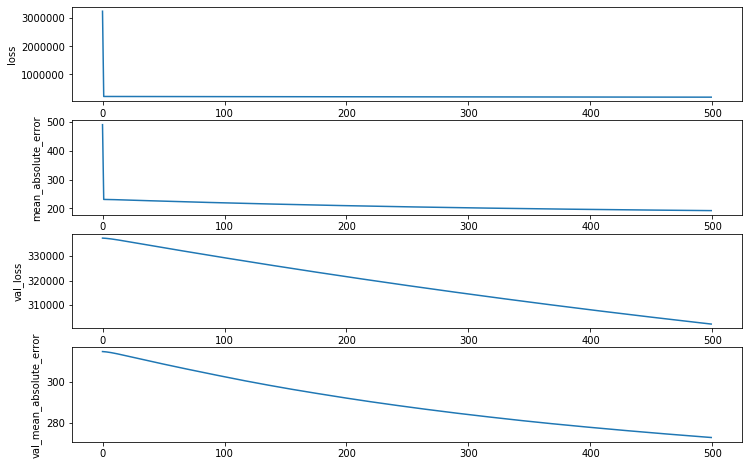

In [34]:
CONV_WIDTH = 28
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*1,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

history = compile_and_fit(multi_conv_model, multi_window, epochs=500)
plot_history(history)

In [35]:
multi_conv_model.predict(multi_window.val)

66/66 [==============================] - 0s 3ms/step - loss: 302335.2188 - mean_absolute_error: 272.6892


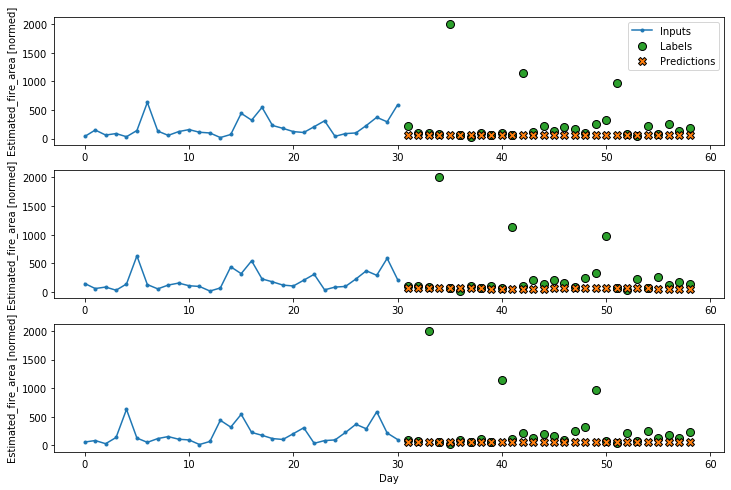

In [36]:
val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

Try Autoregressive model

In [37]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)
    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state
    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the lstm state
        prediction, state = self.warmup(inputs)

        # Insert the first prediction
        predictions.append(prediction)

        # Run the rest of the prediction steps
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state,
                                      training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions


In [38]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)
prediction, state = feedback_model.warmup(multi_window.example[0])
print('prediction.shape', prediction.shape)
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

prediction.shape (16, 31)
Output shape (batch, time, features):  (16, 28, 31)


Epoch 1/200
239/239 [==============================] - 5s 21ms/step - loss: 211127.0781 - mean_absolute_error: 227.9404 - val_loss: 333289.1562 - val_mean_absolute_error: 308.4191
Epoch 2/200
239/239 [==============================] - 4s 16ms/step - loss: 208718.3438 - mean_absolute_error: 222.8416 - val_loss: 330293.6875 - val_mean_absolute_error: 303.8843
Epoch 3/200
239/239 [==============================] - 4s 16ms/step - loss: 206650.3281 - mean_absolute_error: 218.8036 - val_loss: 327522.6250 - val_mean_absolute_error: 299.8148
Epoch 4/200
239/239 [==============================] - 4s 15ms/step - loss: 204699.7500 - mean_absolute_error: 215.1965 - val_loss: 324868.7188 - val_mean_absolute_error: 296.1758
Epoch 5/200
239/239 [==============================] - 4s 17ms/step - loss: 202835.9375 - mean_absolute_error: 211.9221 - val_loss: 322311.7812 - val_mean_absolute_error: 292.8849
Epoch 6/200
239/239 [==============================] - 4s 18ms/step - loss: 201048.4375 - mean_absol

239/239 [==============================] - 2s 10ms/step - loss: 166530.7500 - mean_absolute_error: 189.9424 - val_loss: 266010.5000 - val_mean_absolute_error: 259.1974
Epoch 47/200
239/239 [==============================] - 2s 10ms/step - loss: 166217.4375 - mean_absolute_error: 190.3215 - val_loss: 265382.6250 - val_mean_absolute_error: 259.2892
Epoch 48/200
239/239 [==============================] - 2s 10ms/step - loss: 165918.6250 - mean_absolute_error: 190.7090 - val_loss: 264776.2188 - val_mean_absolute_error: 259.3966
Epoch 49/200
239/239 [==============================] - 2s 10ms/step - loss: 165633.6875 - mean_absolute_error: 191.0995 - val_loss: 264190.5938 - val_mean_absolute_error: 259.5183
Epoch 50/200
239/239 [==============================] - 2s 10ms/step - loss: 165362.0625 - mean_absolute_error: 191.4939 - val_loss: 263625.0938 - val_mean_absolute_error: 259.6481
Epoch 51/200
239/239 [==============================] - 2s 10ms/step - loss: 165103.1562 - mean_absolute_err

239/239 [==============================] - 2s 10ms/step - loss: 160677.8594 - mean_absolute_error: 205.4274 - val_loss: 251355.6719 - val_mean_absolute_error: 266.5556
Epoch 92/200
239/239 [==============================] - 2s 10ms/step - loss: 160643.8281 - mean_absolute_error: 205.6666 - val_loss: 251216.4219 - val_mean_absolute_error: 266.6866
Epoch 93/200
239/239 [==============================] - 2s 10ms/step - loss: 160611.4062 - mean_absolute_error: 205.9014 - val_loss: 251081.4219 - val_mean_absolute_error: 266.8147
Epoch 94/200
239/239 [==============================] - 3s 10ms/step - loss: 160580.8281 - mean_absolute_error: 206.1316 - val_loss: 250950.6562 - val_mean_absolute_error: 266.9412
Epoch 95/200
239/239 [==============================] - 2s 10ms/step - loss: 160551.5625 - mean_absolute_error: 206.3569 - val_loss: 250823.8594 - val_mean_absolute_error: 267.0652
Epoch 96/200
239/239 [==============================] - 4s 15ms/step - loss: 160523.7969 - mean_absolute_err

239/239 [==============================] - 3s 12ms/step - loss: 160048.2188 - mean_absolute_error: 212.3368 - val_loss: 247874.5938 - val_mean_absolute_error: 270.4150
Epoch 137/200
239/239 [==============================] - 3s 12ms/step - loss: 160044.3750 - mean_absolute_error: 212.4223 - val_loss: 247837.4531 - val_mean_absolute_error: 270.4630
Epoch 138/200
239/239 [==============================] - 3s 13ms/step - loss: 160040.5156 - mean_absolute_error: 212.5059 - val_loss: 247801.3750 - val_mean_absolute_error: 270.5099
Epoch 139/200
239/239 [==============================] - 3s 12ms/step - loss: 160037.1406 - mean_absolute_error: 212.5873 - val_loss: 247766.2188 - val_mean_absolute_error: 270.5558
Epoch 140/200
239/239 [==============================] - 3s 12ms/step - loss: 160033.7656 - mean_absolute_error: 212.6667 - val_loss: 247732.1094 - val_mean_absolute_error: 270.6005
Epoch 141/200
239/239 [==============================] - 3s 12ms/step - loss: 160030.4375 - mean_absolut

239/239 [==============================] - 4s 18ms/step - loss: 159966.1250 - mean_absolute_error: 214.6733 - val_loss: 246895.2500 - val_mean_absolute_error: 271.7280
Epoch 182/200
239/239 [==============================] - 4s 17ms/step - loss: 159965.4219 - mean_absolute_error: 214.7006 - val_loss: 246884.0469 - val_mean_absolute_error: 271.7432
Epoch 183/200
239/239 [==============================] - 4s 16ms/step - loss: 159964.6250 - mean_absolute_error: 214.7271 - val_loss: 246873.1250 - val_mean_absolute_error: 271.7581
Epoch 184/200
239/239 [==============================] - 4s 15ms/step - loss: 159963.8438 - mean_absolute_error: 214.7529 - val_loss: 246862.4531 - val_mean_absolute_error: 271.7725
Epoch 185/200
239/239 [==============================] - 4s 15ms/step - loss: 159963.1875 - mean_absolute_error: 214.7782 - val_loss: 246852.0938 - val_mean_absolute_error: 271.7866
Epoch 186/200
239/239 [==============================] - 4s 16ms/step - loss: 159962.5156 - mean_absolut

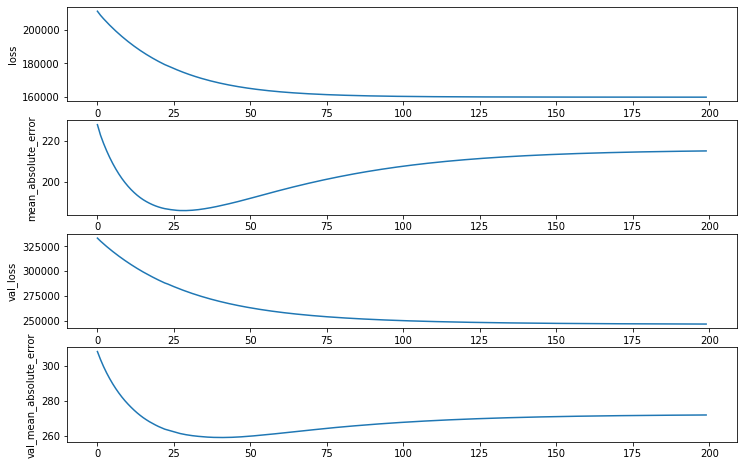

In [39]:
history_ar = compile_and_fit(feedback_model, multi_window, epochs=200)
plot_history(history_ar)

66/66 [==============================] - 0s 5ms/step - loss: 246724.0000 - mean_absolute_error: 271.9590


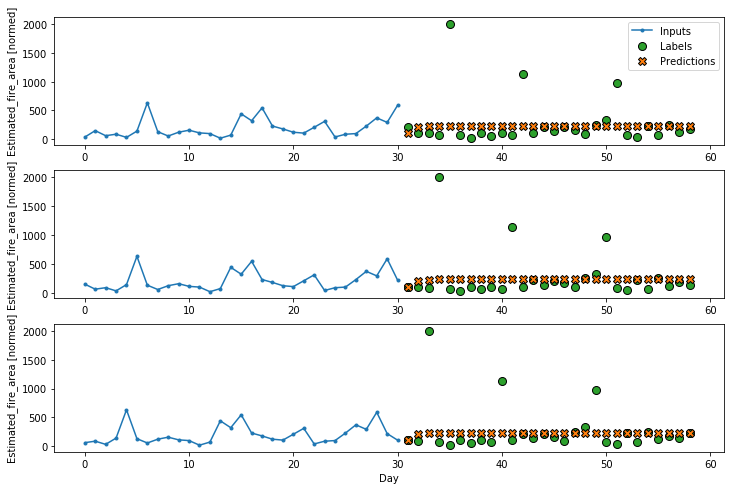

In [40]:
val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

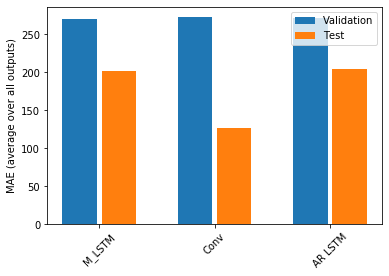

In [41]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [37]:
for example_inputs, example_labels in multi_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (16, 5, 3)
Labels shape (batch, time, features): (16, 5, 1)
